In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import re
from seaborn.widgets import cubehelix_palette
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from pprint import pprint
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier

In [6]:
df = pd.read_csv('data\Training Data_processed.csv')

Algoritmos a serem utilizados:
- Árvore de Decisão;
- K-Vizinhos Mais Próximos (K-NN) - variando-se 3 vezes o número do parâmetro k;
- Random Forest
- XGBoost

In [10]:
df = df.drop('Unnamed: 0', axis=1)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Id                            252000 non-null  int64  
 1   income                        252000 non-null  int64  
 2   age                           252000 non-null  int64  
 3   experience                    252000 non-null  int64  
 4   profession                    252000 non-null  float64
 5   city                          252000 non-null  float64
 6   state                         252000 non-null  float64
 7   current_job_years             252000 non-null  int64  
 8   current_house_years           252000 non-null  int64  
 9   risk_flag                     252000 non-null  int64  
 10  married_married               252000 non-null  bool   
 11  married_single                252000 non-null  bool   
 12  house_ownership_norent_noown  252000 non-nul

In [ ]:
def treinamento_modelo(estimador, X_train, X_test, y_train):
    """
    Treina um modelo com os dados de treinamento e faz previsões com os dados de teste.

    Args:
        estimador: Um modelo de aprendizado de máquina (classificador/regressor).
        X_train: Dados de treinamento.
        X_test: Dados de teste.
        y_train: Rótulos de treinamento.

    Returns:
        y_pred: Rótulos previstos pelo modelo.
    """
    estimador.fit(X_train, y_train)
    y_pred = estimador.predict(X_test)

    return y_pred


def analise_curva_ROC_AUC(lista_modelos, X_train, X_test, y_train, y_test):
    """
    Esta função treina vários modelos e avalia seu desempenho usando métricas como acurácia, precisão, revocação e F1-score.
    Também plota a curva ROC-AUC e a matriz de confusão para cada modelo.

    Args:
        lista_modelos: Uma lista de dicionários contendo informações sobre os modelos a serem treinados.
        X_train: Dados de treinamento.
        X_test: Dados de teste.
        y_train: Rótulos de treinamento.
        y_test: Rótulos de teste.

    Returns:
        dict: Um dicionário com as métricas de desempenho de cada modelo.
    """

    print(f"\n\n\n **** RESULTADO DOS MODELOS + CURVA ROC-AUC ****\n")

    resposta = {}

    for mdl in lista_modelos:
        nome_do_modelo = mdl["nome_do_modelo"]
        estimador = mdl.get('estimador')

        y_pred = treinamento_modelo(estimador, X_train, X_test, y_train)

        fpr, tpr, thresholds = metrics.roc_curve(y_test, estimador.predict_proba(X_test)[:,1]) #Calculo da curva ROC

        # Cálculo das métricas de desempenho
        model_name = mdl.get('nome_do_modelo')
        accuracy = metrics.accuracy_score(y_test, y_pred)
        auc = metrics.roc_auc_score(y_test, estimador.predict(X_test))
        precision = metrics.precision_score(y_test, y_pred, average='weighted')
        recall = metrics.recall_score(y_test, y_pred, average='weighted')
        f1_score = metrics.f1_score(y_test, y_pred, average='weighted')

        plt.plot(fpr, tpr, label='%s ROC (AUC = %0.2f)' % (mdl.get('nome_do_modelo'), auc)) #Plotagem da curva ROC de cada modelo

        print(f"Modelo     : {nome_do_modelo}")
        print(f"Acurácia   : {accuracy:.5f}")
        print(f"Precisão   : {precision:.5f}")
        print(f"Revocação  : {recall:.5f}")
        print(f"F1 - Score : {f1_score:.5f}")
        print(f"ROC - AUC  : {auc:.5f}\n\n{'='*50}\n")

        resposta[mdl.get('nome_do_modelo')]  = {
            "Acurácia": accuracy,
            "Precisão": precision,
            "Revocação": recall,
            "f1_score": f1_score,
            "auc": auc,
        }

    #Plotagem da curva ROC geral
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Verdadeiro Positivo')
    plt.ylabel('Taxa de Falso Positivo')
    plt.title('CURVA ROC-AUC')
    plt.legend(loc="lower right")
    plt.show()

    return resposta

def dataframe_resposta(pipeline_resposta):
    """
    Cria um DataFrame a partir do resultado dos modelos contendo as métricas de desempenho de modelos.
    Args:
        pipeline_resposta: Um dicionário que contém métricas de desempenho para diferentes modelos.
    Returns:
        metricas_df: Um DataFrame que contém as métricas organizadas por modelo.
    """
    resp = []
    for modelo, modelo_metricas  in pipeline_resposta.items():
      metricas = []
      metricas.append(modelo)
      for metrica in modelo_metricas.values():
        metricas.append(metrica)
      resp.append(metricas)

    metricas_df = pd.DataFrame(resp, columns=['modelo'] + list(pipeline_resposta['Decision Tree'].keys()))
    return metricas_df

random_seed = 42 #garantir reprodutibilidade

#Lista de modelos utilizados para essa primeira análise
lista_modelos = [
  {
      "nome_do_modelo": "Decision Tree",
      "estimador": DecisionTreeClassifier(random_state=random_seed)
  },
  {
      "nome_do_modelo": "Random Forest",
      "estimador": RandomForestClassifier(random_state=random_seed)
  },
  {
      "nome_do_modelo": "XGBoost",
      "estimador": XGBClassifier(random_state=random_seed)
  },
  {
      "nome_do_modelo": "KNN",
      "estimador": ''
  }
]

In [25]:
def treinamento_modelo(estimador, X_train, y_train):
    """
    Treina um modelo com os dados de treinamento.

    Args:
        estimador: Um modelo de aprendizado de máquina (classificador/regressor).
        X_train: Dados de treinamento.
        y_train: Rótulos de treinamento.

    Returns:
        estimador_treinado: O modelo treinado.
    """
    estimador_treinado = estimador.fit(X_train, y_train)
    return estimador_treinado

def analise_curva_ROC_AUC(lista_modelos, X, y):
    """
    Esta função treina vários modelos e avalia seu desempenho usando métricas como acurácia, precisão, revocação e F1-score.
    Também plota a curva ROC-AUC e a matriz de confusão para cada modelo.

    Args:
        lista_modelos: Uma lista de dicionários contendo informações sobre os modelos a serem treinados.
        X: Conjunto de dados.
        y: Rótulos.

    Returns:
        dict: Um dicionário com as métricas de desempenho de cada modelo.
    """

    print(f"\n\n\n **** RESULTADO DOS MODELOS + CURVA ROC-AUC ****\n")

    resposta = {}

    for mdl in lista_modelos:
        nome_do_modelo = mdl["nome_do_modelo"]
        estimador = mdl.get('estimador')
        parametros = mdl.get('parametros')

        # Configurando a validação cruzada
        cv_outer = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_inner = KFold(n_splits=10, shuffle=True, random_state=42)

        # Configurando a busca em grade
        grid_search = GridSearchCV(estimador, parametros, scoring='roc_auc', cv=cv_inner, n_jobs=-1)

        # Executando a validação cruzada
        cv_results = []
        for train_ix, test_ix in cv_outer.split(X):
            X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
            y_train, y_test = y[train_ix], y[test_ix]
            grid_search.fit(X_train, y_train)
            y_pred_proba = grid_search.predict_proba(X_test)[:, 1]  # Probabilidades da classe positiva
            fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)  # Calcula FPR e TPR
            auc_score = metrics.roc_auc_score(y_test, y_pred_proba)  # Calcula AUC
            cv_results.append(auc_score)

            # Plotagem da curva ROC de cada modelo
            plt.plot(fpr, tpr, label='%s ROC (AUC = %0.2f)' % (mdl.get('nome_do_modelo'), auc_score))

        auc_mean = np.mean(cv_results)
        auc_std = np.std(cv_results)

        # Obtendo o melhor modelo
        best_model = grid_search.best_estimator_

        # Cálculo das métricas de desempenho
        accuracy = best_model.score(X, y)
        precision = metrics.precision_score(y, best_model.predict(X), average='weighted')
        recall = metrics.recall_score(y, best_model.predict(X), average='weighted')
        f1_score = metrics.f1_score(y, best_model.predict(X), average='weighted')

        print(f"Modelo     : {nome_do_modelo}")
        print(f"Acurácia   : {accuracy:.5f}")
        print(f"Precisão   : {precision:.5f}")
        print(f"Revocação  : {recall:.5f}")
        print(f"F1 - Score : {f1_score:.5f}")
        print(f"ROC - AUC  : {auc_mean:.5f} +/- {auc_std:.5f}\n\n{'='*50}\n")

        resposta[mdl.get('nome_do_modelo')]  = {
            "Acurácia": accuracy,
            "Precisão": precision,
            "Revocação": recall,
            "f1_score": f1_score,
            "auc_mean": auc_mean,
            "auc_std": auc_std
        }

    #Plotagem da curva ROC geral
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falso Positivo')
    plt.ylabel('Taxa de Verdadeiro Positivo')
    plt.title('CURVA ROC-AUC')
    plt.legend(loc="lower right")
    plt.show()

    return resposta

# Lista de modelos com parâmetros para busca em grade
lista_modelos = [
    {
        "nome_do_modelo": "Decision Tree",
        "estimador": DecisionTreeClassifier(),
        "parametros": {'max_depth': [3, 5, 7]}
    },
    {
        "nome_do_modelo": "Random Forest",
        "estimador": RandomForestClassifier(),
        "parametros": {'n_estimators': [50, 100, 200]}
    },
    {
        "nome_do_modelo": "XGBoost",
        "estimador": XGBClassifier(),
        "parametros": {'max_depth': [3, 5, 7]}
    },
    {
        "nome_do_modelo": "KNN",
        "estimador": KNeighborsClassifier(),
        "parametros": {'n_neighbors': [3, 5, 7]}
    }
]

In [33]:
#Remover a coluna risk_flag dos dados, extraindo as features na variável X
X = df.drop(['risk_flag'], axis = 1)
y = df['risk_flag']

In [34]:
# Padronização/Normalizando dos dados utilizando o StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std = pd.DataFrame(X_std, index=X.index, columns=X.columns)




 **** RESULTADO DOS MODELOS + CURVA ROC-AUC ****

Modelo     : Decision Tree
Acurácia   : 0.87736
Precisão   : 0.85557
Revocação  : 0.87736
F1 - Score : 0.82091
ROC - AUC  : 0.68415 +/- 0.00454




KeyboardInterrupt: 

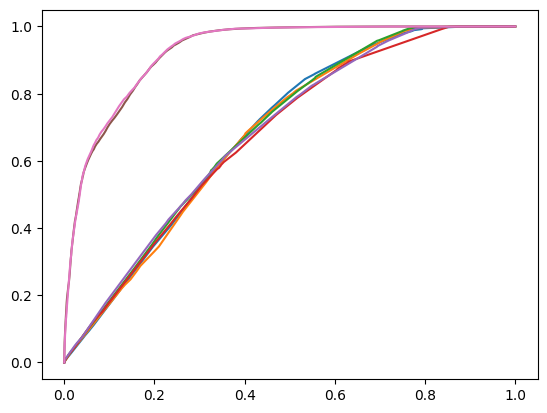

In [36]:
analise_curva_ROC_AUC(lista_modelos, X_std, y)